# Text-to-Image and Image-to-image search Using CLIP

# Install libraries

In [1]:
!pip install -qU transformers torch datasets gdcm pydicom pinecone-client scikit-image scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
start = time.time()

# Import libraries

In [3]:
import os
import torch
import skimage
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pinecone


c:\Users\jayit\Image-Search\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Image Exploration

## Load Data

In [4]:
# https://huggingface.co/datasets/conceptual_captions
image_data = load_dataset(
    "ashraq/fashion-product-images-small", split="train",
    )

In [5]:
image_data

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

We will select a sample of 300 images from this large number of images (3 318 333)

In [6]:
image_data_df = pd.DataFrame(image_data[:100])

In [7]:
image_data_df.shape

(100, 11)

In [8]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...


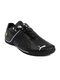

In [9]:
image_data_df.iloc[10]["image"]

In [10]:
def get_model_info(model_ID, device):

  # Save the model to device
  model = CLIPModel.from_pretrained(model_ID).to(device)

  # Get the processor
  processor = CLIPProcessor.from_pretrained(model_ID)

  # Get the tokenizer
  tokenizer = CLIPTokenizer.from_pretrained(model_ID)

  # Return model, processor & tokenizer
  return model, processor, tokenizer

In [11]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ID = "openai/clip-vit-base-patch32"

model, processor, tokenizer = get_model_info(model_ID, device)

# Create Embeddings: Text and Image Embeddings

## Text Embeddings

In [12]:
def get_single_text_embedding(text):

  inputs = tokenizer(text, return_tensors = "pt").to(device)

  text_embeddings = model.get_text_features(**inputs)

  # convert the embeddings to numpy array
  embedding_as_np = text_embeddings.cpu().detach().numpy()

  return embedding_as_np

In [13]:
def get_all_text_embeddings(df, text_col):

   df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)

   return df

In [14]:
image_data_df = get_all_text_embeddings(image_data_df, "productDisplayName")

In [15]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,text_embeddings
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.3475988, 0.18605354, -0.0343706, -0.087694..."
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.23037615, 0.07004118, 0.18918844, 0.107768..."
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.035211116, -0.045803487, 0.113766454, 0.00..."
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.29978237, 0.14450417, -0.11682534, 0.31130..."
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.11817148, -0.15154779, -0.40441728, 0.1066..."


## Image Embeddings

In [16]:
def get_single_image_embedding(my_image):

  image = processor(
      text = None,
      images = my_image,
      return_tensors="pt"
  )["pixel_values"].to(device)

  embedding = model.get_image_features(image)

  # convert the embeddings to numpy array
  embedding_as_np = embedding.cpu().detach().numpy()

  return embedding_as_np

### Get the embedding of all the images

In [17]:
def get_all_images_embedding(df, img_column):

  df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)

  return df

In [18]:
image_data_df = get_all_images_embedding(image_data_df, "image")

In [19]:
image_data_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,text_embeddings,img_embeddings
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.3475988, 0.18605354, -0.0343706, -0.087694...","[[0.04691638, 0.25467515, -0.120271295, 0.0359..."
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.23037615, 0.07004118, 0.18918844, 0.107768...","[[0.0713589, -0.07549217, -0.014071882, 0.2936..."
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.035211116, -0.045803487, 0.113766454, 0.00...","[[-0.1472764, 0.046212614, 0.12650895, -0.2318..."
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.29978237, 0.14450417, -0.11682534, 0.31130...","[[-0.034854814, 0.094139814, -0.08228813, 0.40..."
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[[0.11817148, -0.15154779, -0.40441728, 0.1066...","[[-0.46638542, 0.29436123, -0.30414253, -0.087..."


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images):

  for image in images:
    plt.imshow(image)
    plt.show()

def plot_images_by_side(top_images):

  index_values = list(top_images.index.values)
  list_images = [top_images.iloc[idx].image for idx in index_values]
  list_captions = [top_images.iloc[idx].productDisplayName for idx in index_values]
  similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]

  n_row = n_col = 2

  _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
  axs = axs.flatten()
  for img, ax, caption, sim_score in zip(list_images, axs, list_captions, similarity_score):
      ax.imshow(img)
      sim_score = 100*float("{:.2f}".format(sim_score))
      ax.title.set_text(f"Caption: {caption}\nSimilarity: {sim_score}%")
  plt.show()

# Perform Similarity Search: Cosine

## 1. Cosine Similarity Search

In [21]:
def get_top_N_images(query, data, top_K=4, search_criterion="text"):

    """
    Retrieve top_K (5 is default value) articles similar to the query
    """
    # Text to image Search
    if(search_criterion.lower() == "text"):
      query_vect = get_single_text_embedding(query)

    # Image to image Search
    else:
      query_vect = get_single_image_embedding(query)

    # Relevant columns
    revevant_cols = ["productDisplayName", "image", "cos_sim"]

    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))

    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])

    """
    Sort Cosine Similarity Column in Descending Order
    Here we start at 1 to remove similarity with itself because it is always 1
    """
    most_similar_articles = data.sort_values(by='cos_sim', ascending=False)[1:top_K+1]

    return most_similar_articles[revevant_cols].reset_index()

In [22]:
image_data_df.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image',
       'text_embeddings', 'img_embeddings'],
      dtype='object')

### a. Text to image search

In [23]:
query_caption = image_data_df.iloc[10].productDisplayName

top_images = get_top_N_images(query_caption, image_data_df)
print("Query: {}".format(query_caption))
top_images

Query: Puma Men Future Cat Remix SF Black Casual Shoes


,index,productDisplayName,image,cos_sim
0,71,Vans Men Khaki Shoes,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0.305623
1,88,Puma Men Axis White & Grey Sports Shoes,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0.296632
2,33,Gas Men Europa White Shoes,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0.293924
3,65,Vans Men Classic Slip-On Purple & Black Shoes,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0.281116


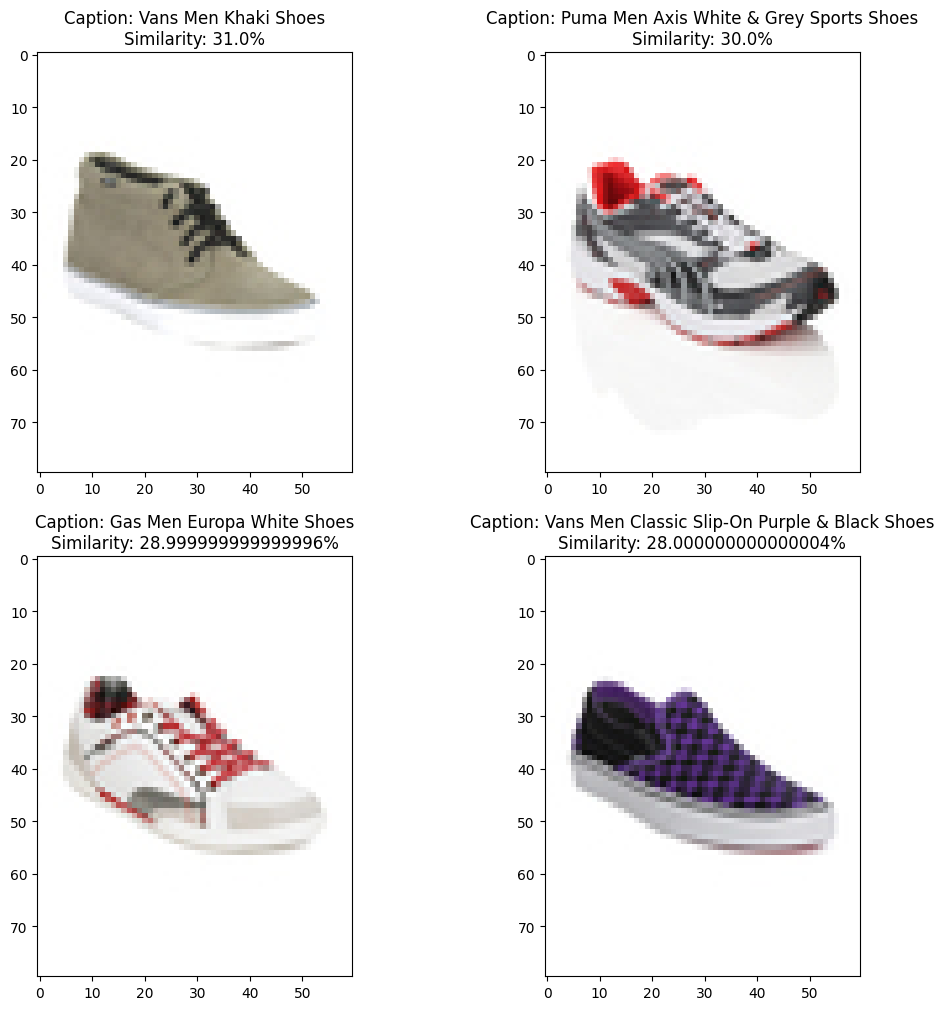

In [24]:
plot_images_by_side(top_images)

### b. Image to image search

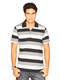

In [25]:
query_image = image_data_df.iloc[55].image
query_image

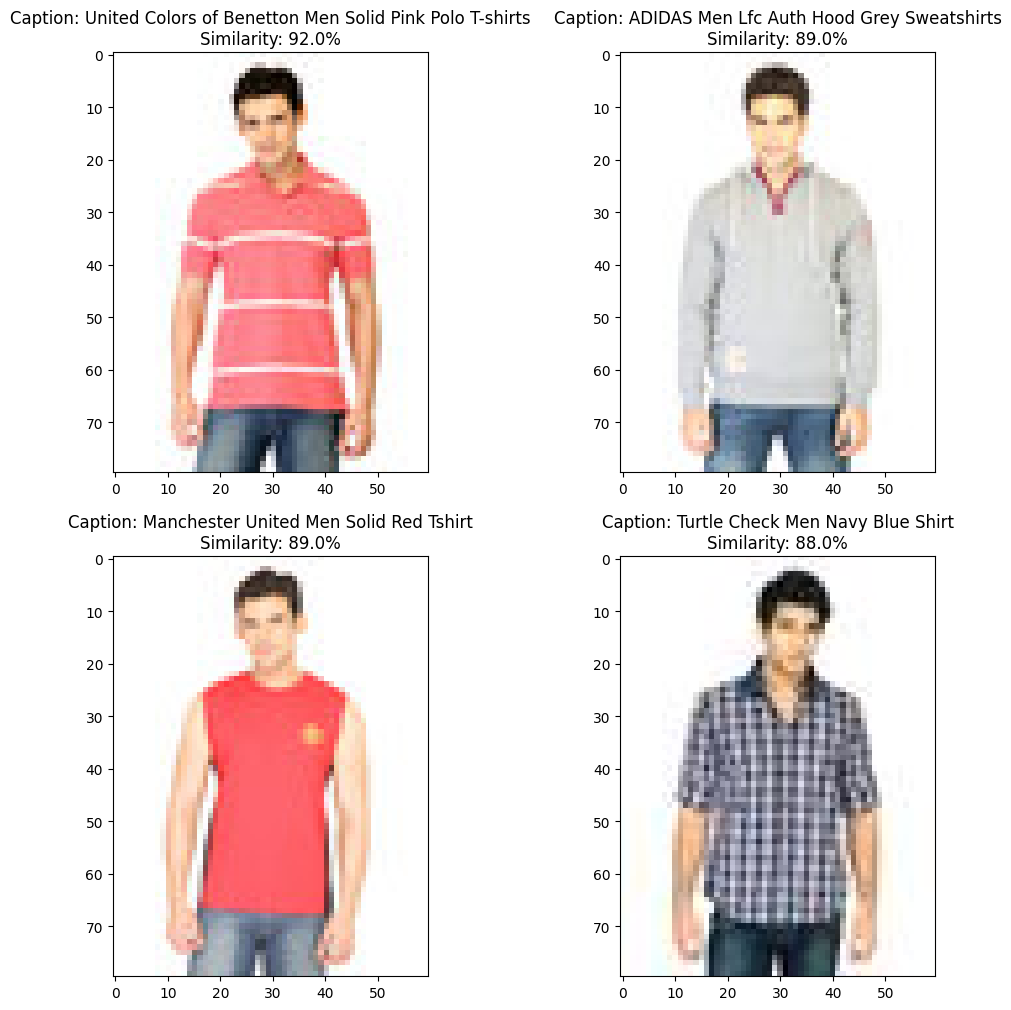

In [26]:
top_images = get_top_N_images(query_image, image_data_df, search_criterion="image")
plot_images_by_side(top_images)

In [27]:
end = time.time()
total_time = end - start
total_time

40.973233222961426